![logo](../../../LogoLine_horizon_C3S.png)

# Satellite Sea Surface Temperature Consistency in representing Ocean Warming Trends

Production date: 16-05-2025

Produced by: CNR-ISMAR

## 🌍 Use case: Using Sea Surface Temperature to monitor ocean surface warming

## ❓ Quality assessment question
* **How well do SST trend estimates obtained from ESA CCI L4 v2.1 and GHRSST Multi-Product Ensemble (GMPE) compare with each other?**

Our aim here is to evaluate the reliability and representativeness of sea surface temperature (SST) linear trends in satellite-based long-term climate data records (CDRs). To this end, two different SST CDRs have been intercompared over a common 30-year long period (1982-2011).

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Both datasets correctly capture the long-term SST trend at both global and regional scale; 							
* The spatial pattern of the SST trend evidences that the Northern Hemisphere is experiencing a more intense warming compared to  the Southern Hemisphere, as reported in literature ([[1]](https://doi.org/10.1007/s00382-014-2147-z), [[2]](https://doi.org/10.1175/JCLI-D-20-0793.1));
* ESA CCI L4 v2.1 tends to exhibit higher trend estimates compared to GMPE, which serves as a reference dataset due to its nature, particularly in certain ocean basins like the Tropical Atlantic and Northern Indian Ocean;
* On average, the global mean SST trend estimates provided by the two datasets are consistent within the 95% confidence interval;
```

```{figure} c3c17d69-0c57-4673-a04b-f10787dc8333.png
---
height: 400px
width: 800px
---
*Linear trends (1982-2011) of ESA CCI and GMPE SSTs*
```

## 📋 Methodology
 
We evaluate the reliability and representativeness of Sea Surface Temperature (SST) linear trends in satellite-based long-term climate data records (CDRs). To this end, two different SST CDRs have been intercompared over a common 30-year long period (1982-2011). 
Respectively, catalogue entries available from the CDS are the following:

* Sea surface temperature daily gridded data from 1981 to 2016 derived from a multi-product satellite-based ensemble - from the Group for High Resolution Sea Surface Temperature (GHRSST) multi-product ensemble (GMPE) produced by the European Space Agency Climate Change Initiative SST (ESA CCI SST) (GMPE in the following). The GMPE SST is obtained as the ensemble median of 16 global contributing Level-4 (L4) analyses (including the ESA CCI v2.0 and v1.1)  [[3]](https://doi.org/10.1016/j.rse.2018.12.015);
* Sea Surface Temperature daily data from 1981 to present derived from satellite observations, ESA CCI SST L4 dataset v2.1 (ESA CCI SST in the following). This L4 datasets provides daily global SST fields from the merging  of space born Infrared SSTs through a variational assimilation algorithm [[4]](https://doi.org/10.1038/s41597-019-0236-x);

The methodology employed is suitable to monitor surface ocean warming over a climatological standard period.

-Annual and seasonal reductions (linear trend with Mann-Kendall test to estimate its significance at 95% confidence level) have been computed over the time axis, and shown as maps. In these maps, patches denote grid points in which there’s no significant trend;

-To have a closer look at areas of major trend discrepancies between the two datasets, time series of spatially averaged annual mean SST, with their trends, have been computed over Tropical Atlantic and Northern Indian Ocean;

-Linear trend estimates were retrieved with the same method used for producing trend maps, described above;

-Superimposed to the time series, also the absolute differences plot on a twin axis illustrate how discrepancies are not homogenous in time.

The analysis and results are organised in the following steps, which are detailed in the sections below: 

**[](satellite_satellite-sea-surface-temperature_consistency_q02:section-1)**

**[](satellite_satellite-sea-surface-temperature_consistency_q02:section-2)**

**[](satellite_satellite-sea-surface-temperature_consistency_q02:section-3)**

**[](satellite_satellite-sea-surface-temperature_consistency_q02:section-4)**
 * 4.1 Plot Annual trend maps
 * 4.2 Seasonal Trends
 * 4.3 SST Time series and trends over Tropical Atlantic and Northern Indian Ocean.

## 📈 Analysis and results
(satellite_satellite-sea-surface-temperature_consistency_q02:section-1)=
### 1. Import packages and define parameters for the requests to the CDS
In the following cell the necessary packages are imported, defining parameters for the request and trend calculation.

In [1]:
import tempfile

import cacholote
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import tqdm
import xarray as xr
from c3s_eqc_automatic_quality_control import download, plot, utils, diagnostics
from xarrayMannKendall import Mann_Kendall_test

plt.style.use("seaborn-v0_8-notebook")

# Time
year_start = 1982
year_stop = 2011
year_timeseries_stop = 2016

# Choose timeseries
seasonal = False
assert isinstance(seasonal, bool)

# Requests
request_dicts = {
    "ESACCI": {
        "collection_id": "satellite-sea-surface-temperature",
        "request": {
            "processinglevel": "level_4",
            "format": "zip",
            "variable": "all",
            "sensor_on_satellite": "combined_product",
            "version": "2_1",
        },
        "chunks": {"year": 1, "month": 1},
    },
    "GMPE": {
        "collection_id": "satellite-sea-surface-temperature-ensemble-product",
        "request": {
            "format": "zip",
            "variable": "all",
        },
        "chunks": {"year": 1, "month": 1, "day": 12},  # CDS limit is 12
    },
}

# Parameters to speed up I/O
open_mfdataset_kwargs = {
    "concat_dim": "time",
    "combine": "nested",
    "data_vars": "minimal",
    "coords": "minimal",
    "compat": "override",
    "parallel": True,
}

(satellite_satellite-sea-surface-temperature_consistency_q02:section-2)=
### 2. Define functions to cache
Functions for rechunking to optimize caching of intermediate results, get nan values on land, convert to degree Celsius in the ocean and calculate the trend are defined below.

In [2]:
def get_masked_sst(ds):
    da = ds["analysed_sst"]
    if "mask" in ds:
        da = da.where(ds["mask"] == 1)
    with xr.set_options(keep_attrs=True):
        da -= 273.15
    da.attrs["units"] = "°C"
    return da


def add_chunksizes(da):
    da.encoding["chunksizes"] = tuple(map(max, da.chunks))
    return da


def rechunk(obj):
    """Use NetCDF chunks."""
    chunks = {"time": 1, "year": 1, "season": 1, "latitude": 1_200, "longitude": 2_400}
    obj = obj.chunk(
        **{dim: chunksize for dim, chunksize in chunks.items() if dim in obj.dims}
    )
    if isinstance(obj, xr.DataArray):
        return add_chunksizes(obj)
    for da in obj.data_vars.values():
        add_chunksizes(da)
    return obj


def compute_low_resolution(ds, freq):
    ds = rechunk(ds)
    da = get_masked_sst(ds)
    target_sizes = {"latitude": 720, "longitude": 1440}
    coarsen_dims = {
        dim: ratio
        for dim, target_size in target_sizes.items()
        if (ratio := da.sizes[dim] // target_size) > 1
    }
    with xr.set_options(keep_attrs=True):
        if coarsen_dims:
            da = da.coarsen(coarsen_dims).mean()
        da = da.sortby("time").resample(time=freq).mean()
    for coord in da.coords:
        da[coord].attrs = ds[coord].attrs
    return rechunk(da).to_dataset()


def _mann_kendall(da, skipna, **kwargs):
    if not skipna:
        da = da.where(da.notnull().all("time"))
    da = da.chunk({dim: -1 if dim == "time" else "auto" for dim in da.dims})
    coords_name = {"time": "time", "x": "longitude", "y": "latitude"}
    with tempfile.TemporaryDirectory() as tmpdir:
        da.to_zarr(tmpdir)
        da = xr.open_dataarray(tmpdir, engine="zarr", chunks=dict(da.chunksizes))
        ds_trend = Mann_Kendall_test(da, coords_name=coords_name, **kwargs).compute()

    ds_trend = ds_trend.rename({k: v for k, v in coords_name.items() if k != "time"})
    for coord in ds_trend.coords:
        ds_trend[coord].attrs = da[coord].attrs
    ds_trend["trend"].attrs["long_name"] = f"Trend of {da.attrs['long_name']}"
    return ds_trend


@cacholote.cacheable
def compute_mann_kendall_trend(
    collection_id,
    request,
    chunks,
    year_start,
    year_stop,
    seasonal,
    open_mfdataset_kwargs,
    skipna,
    **mann_kendall_kwargs,
):
    dataarrays = []
    for year in tqdm.tqdm(range(year_start, year_stop + 1), desc="annual"):
        requests = download.update_request_date(
            request, start=f"{year - 1}-12", stop=f"{year}-11", stringify_dates=True
        )
        ds = download.download_and_transform(
            collection_id=collection_id,
            requests=requests,
            chunks=chunks,
            transform_chunks=False,
            transform_func=compute_low_resolution,
            transform_func_kwargs={"freq": "QE-DEC" if seasonal else "MS"},
            **open_mfdataset_kwargs,
        )
        dataarrays.append(rechunk(ds["analysed_sst"]))
    da = xr.concat(dataarrays, "time")

    if seasonal:
        ds = da.groupby("time.season").map(
            _mann_kendall, skipna=skipna, **mann_kendall_kwargs
        )
        ds["trend"].attrs["units"] = f"{da.attrs['units']}/year"
    else:
        ds = _mann_kendall(
            da.groupby("time.year")
            .mean(keep_attrs=True, skipna=skipna)
            .rename(year="time"),
            skipna=skipna,
            **mann_kendall_kwargs,
        )
        ds["trend"].attrs["units"] = f"{da.attrs['units']}/year"
    return rechunk(ds)

(satellite_satellite-sea-surface-temperature_consistency_q02:section-3)=
### 3. Download and transform
In this step the data are requested, retrieved and processed in one step. 

In [3]:
datasets = []
for product, request_dict in request_dicts.items():
    #print(f"{product=}")
    ds = compute_mann_kendall_trend(
        **request_dict,
        year_start=year_start,
        year_stop=year_stop,
        seasonal=seasonal,
        open_mfdataset_kwargs=open_mfdataset_kwargs,
        skipna=False,
        # Mann Kendall settings
        alpha=0.05,
        method="theilslopes",
    )
    for coord in ("longitude", "latitude"):
        ds[coord] = ds[coord].round(3)
    ds = ds.expand_dims(product=[product])
    datasets.append(rechunk(ds))
ds = xr.concat(datasets, "product")

(satellite_satellite-sea-surface-temperature_consistency_q02:section-4)=
### 4. Plot Annual and Seasonal trends, SST Time series and trends over Tropical Atlantic and Northern Indian Ocean, with discussions

#### 4.1 Plot Annual trend maps
In this section we plot the annual trend maps for each product, discussing differences.

ESACCI in Mediterranean Sea: 0.042 ± 0.014 °C/year
ESACCI in Baltic Sea: 0.044 ± 0.016 °C/year
ESACCI in Black Sea: 0.058 ± 0.018 °C/year
ESACCI in Global: 0.022 ± 0.013 °C/year
ESACCI in Tropical Atlantic: 0.033 ± 0.01 °C/year
ESACCI in Northern Indian Ocean: 0.03 ± 0.008 °C/year
GMPE in Mediterranean Sea: 0.037 ± 0.012 °C/year
GMPE in Baltic Sea: 0.053 ± 0.015 °C/year
GMPE in Black Sea: 0.056 ± 0.015 °C/year
GMPE in Global: 0.018 ± 0.01 °C/year
GMPE in Tropical Atlantic: 0.025 ± 0.0095 °C/year
GMPE in Northern Indian Ocean: 0.019 ± 0.0083 °C/year


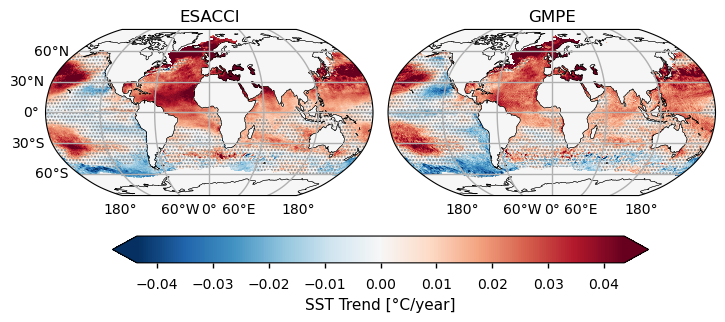

In [4]:
import numpy as np
plt.rcParams.update({'hatch.color': 'grey'})
projection = ccrs.Robinson()
facet = plot.projected_map(
    ds["trend"] if "season" in ds.dims else ds["trend"],
    projection=projection,
    row="season" if "season" in ds.dims else None,
    col="product",
    robust=True,
    center=0,
    cbar_kwargs={'orientation': 'horizontal', 'label': 'SST Trend [°C/year]', 'shrink':0.8}
)
med_sea = [30,46,-6,36]
baltic_sea = [53,66,10,30]
black_sea = [39,48,26,42]
tropAtl = [0,30,-60,0]
NorthInd = [10,30,60,80]
glo = [-90, 90, -180, 180]
regions = [med_sea, baltic_sea, black_sea, glo, tropAtl, NorthInd]
regnames = ['Mediterranean Sea', 'Baltic Sea', 'Black Sea', 'Global', 'Tropical Atlantic', 'Northern Indian Ocean']
for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
    p_value = ds["p"].sel(**sel_dict).reset_coords(drop=True)
    plot.projected_map(
        p_value.where(p_value!=1),
        projection=projection,
        show_stats=False,
        ax=ax,
        cmap="none",
        add_colorbar=False,
        plot_func="contourf",
        levels=[0, 0.05, 1],
        hatches=["", "." * 5],
    )
    for r, rname in zip(regions, regnames):
        p_reg = ds["p"].sel(**sel_dict).reset_coords(drop=True).sel(latitude=slice(r[0], r[1]), longitude=slice(r[2], r[3]))
        p_reg = p_reg.where(p_reg<=0.5)
        t_reg = ds["trend"].sel(**sel_dict).reset_coords(drop=True).sel(latitude=slice(r[0], r[1]), longitude=slice(r[2], r[3])).where(p_reg<=0.05)
        t_reg_avg = t_reg.weighted(np.cos(t_reg.latitude*np.pi/180.)).mean(['latitude', 'longitude'])
        p_reg_avg = p_reg.weighted(np.cos(p_reg.latitude*np.pi/180.)).mean(['latitude', 'longitude'])
        z = -0.862 + (0.743 -2.404*np.log(p_reg_avg))**0.5
        SE = ((t_reg_avg / z)**2)**0.5
        print(f"{str(sel_dict['product'])} in {rname}: {t_reg_avg.values:.2} ± {SE.values:.2} °C/year")
    ax.set_title(str(sel_dict['product']))

The global SST trend map has been computed over 30 years from 1982 to 2011 at the 95% confidence level (grey dots mark non-significant trend areas). SST exhibits an overall positive (warming) trend over the Northern Hemisphere, where it can reach $\simeq$0.05 °C/year, while the Southern Hemisphere is characterized by less significant and negative values. A large area covering the Eastern Pacific Ocean is characterized by no significant trends (i.e., p $\geq$ 0.05) with few sparse significant values in both ESA CCI and GMPE. The North Atlantic ocean and the European seas stand out showing the most intense SST trend values, as e.g. the Mediterranean Sea (GMPE = 0.04 $\pm$ 0.01 °C/year, ESA CCI = 0.04 $\pm$ 0.01 °C/year), Baltic Sea (GMPE = 0.05 $\pm$ 0.02 °C/year, ESA CCI = 0.04 $\pm$ 0.02 °C/year) and Black Sea (GMPE = 0.06 $\pm$ 0.01 °C/year, ESA CCI = 0.06 $\pm$ 0.02 °C/year). The Mediterranean SST trend is in good agreement with the one reported in [[5]](https://doi.org/10.3390/rs12010132), while Baltic Sea and Black Sea trends are similar to those found in [[6]](https://doi.org/10.1080/1755876X.2018.1489208), but over a shorter period. In the Black and Mediterranean Sea, trend estimates between ESA CCI and GMPE are more in agreement than in the Baltic Sea.

#### 4.2 Seasonal Trends
In this section we plot seasonal trends for each product, discussing the differences.

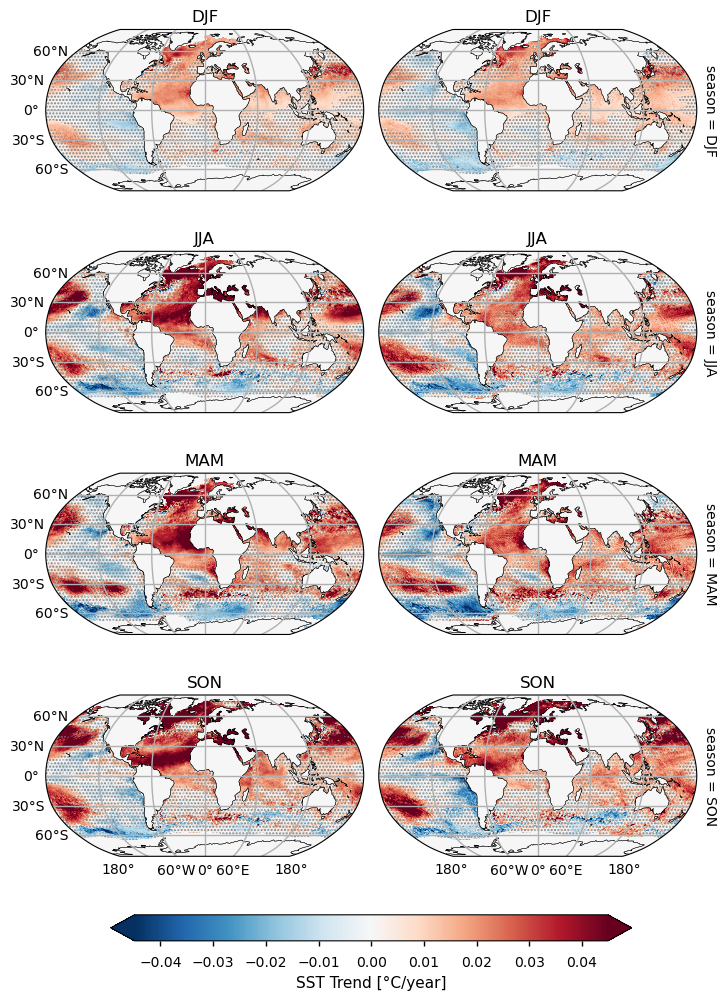

In [9]:
# Choose timeseries
seasonal = True
assert isinstance(seasonal, bool)
datasets = []
for product, request_dict in request_dicts.items():
    #print(f"{product=}")
    ds = compute_mann_kendall_trend(
        **request_dict,
        year_start=year_start,
        year_stop=year_stop,
        seasonal=seasonal,
        open_mfdataset_kwargs=open_mfdataset_kwargs,
        skipna=False,
        # Mann Kendall settings
        alpha=0.05,
        method="theilslopes",
    )
    for coord in ("longitude", "latitude"):
        ds[coord] = ds[coord].round(3)
    ds = ds.expand_dims(product=[product])
    datasets.append(rechunk(ds))
ds = xr.concat(datasets, "product")
# Plot seasonal trends
projection = ccrs.Robinson()
facet = plot.projected_map(
    ds["trend"],
    projection=projection,
    col="product",
    row="season" if "season" in ds.dims else None,
    robust=True,
    center=0,
    cbar_kwargs={'label': 'SST Trend [°C/year]', 'shrink':0.8, 'orientation':'horizontal', 'pad':0.05}
)
for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
    p_value = ds["p"].sel(**sel_dict).reset_coords(drop=True)
    plot.projected_map(
        p_value.where(p_value!=1),
        projection=projection,
        show_stats=False,
        ax=ax,
        cmap="none",
        add_colorbar=False,
        plot_func="contourf",
        levels=[0, 0.05, 1],
        hatches=["", "." * 5],
    )
    ax.set_title(str(sel_dict['season']))

Seasonal maps show an intensification of the trend from Spring to Autumn and an attenuation during winter. Overall the agreement between GMPE and ESA CCI SST is quite good though the former dataset provides less intense trend estimates. Both datasets’ estimates yield a Northern Hemisphere which has warmed up at a higher rate than the Southern Hemisphere, especially in Boreal Summer and Fall.
					
				
The globally averaged mean trend is estimated in 0.018 $\pm$ 0.01 °C/year for GMPE, while for ESA CCI we have 0.022 $\pm$ 0.013 °C/year, which corresponds to an average total increase of about 0.54 °C in GMPE and 0.66 °C in ESA CCI over this 30-year period (1982-2011). Within the 95% confidence interval, both datasets provide consistent estimates of global warming trends. These values are also reasonably consistent (within respective errors) with the mean global trend estimate of 0.011 °C/year from 1980 to 2005 as reported in one of the last IPCC reports [[7]](http://hdl.handle.net/10013/epic.45156.d001), given the different time period on which the trend is calculated. Regionally, estimates of trend slopes yield values for the Northern Indian Ocean (GMPE=0.019 $\pm$ 0.008 °C/year, ESA CCI=0.030 $\pm$ 0.008 °C/year) and Tropical Atlantic (GMPE= 0.025 $\pm$ 0.009 °C/year, ESA CCI=0.003 $\pm$ 0.01 °C/year), which are consistent with each others in the limits of their respective uncertainties, though are areas of main disagreement for trend estimates.
	

#### 4.3 SST Time series and trends over Tropical Atlantic and Northern Indian Ocean

Trend analyses shown in the previous section evidenced the existence of disagreement areas between ESA CCI and GMPE SST datasets. In particular, the Northern Indian Ocean and the Tropical Atlantic exhibit a larger SST trend for the ESA CCI dataset, when compared to GMPE. The ESA CCI and GMPE SST monthly time series were then intercompared in those areas, in order to have further insights on these discrepancies. 

product='ESACCI' region='global'


year: 100%|██████████| 35/35 [00:09<00:00,  3.72it/s]


product='ESACCI' region='med sea'


year: 100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


product='ESACCI' region='baltic sea'


year: 100%|██████████| 35/35 [00:05<00:00,  6.27it/s]


product='ESACCI' region='black sea'


year: 100%|██████████| 35/35 [00:05<00:00,  6.41it/s]


product='ESACCI' region='Tropical Atlantic'


year: 100%|██████████| 35/35 [00:03<00:00,  9.27it/s]


product='ESACCI' region='Northern Indian Ocean'


year: 100%|██████████| 35/35 [00:03<00:00,  8.81it/s]


product='GMPE' region='global'


year: 100%|██████████| 35/35 [00:06<00:00,  5.48it/s]


product='GMPE' region='med sea'


year: 100%|██████████| 35/35 [00:04<00:00,  7.60it/s]


product='GMPE' region='baltic sea'


year: 100%|██████████| 35/35 [00:04<00:00,  7.88it/s]


product='GMPE' region='black sea'


year: 100%|██████████| 35/35 [00:05<00:00,  6.97it/s]


product='GMPE' region='Tropical Atlantic'


year: 100%|██████████| 35/35 [00:07<00:00,  4.54it/s]


product='GMPE' region='Northern Indian Ocean'


year: 100%|██████████| 35/35 [00:54<00:00,  1.56s/it]


ESACCI in Northern Indian Ocean: 0.0018 ± 0.0004 °C/year
GMPE in Northern Indian Ocean: 0.0012 ± 0.0005 °C/year


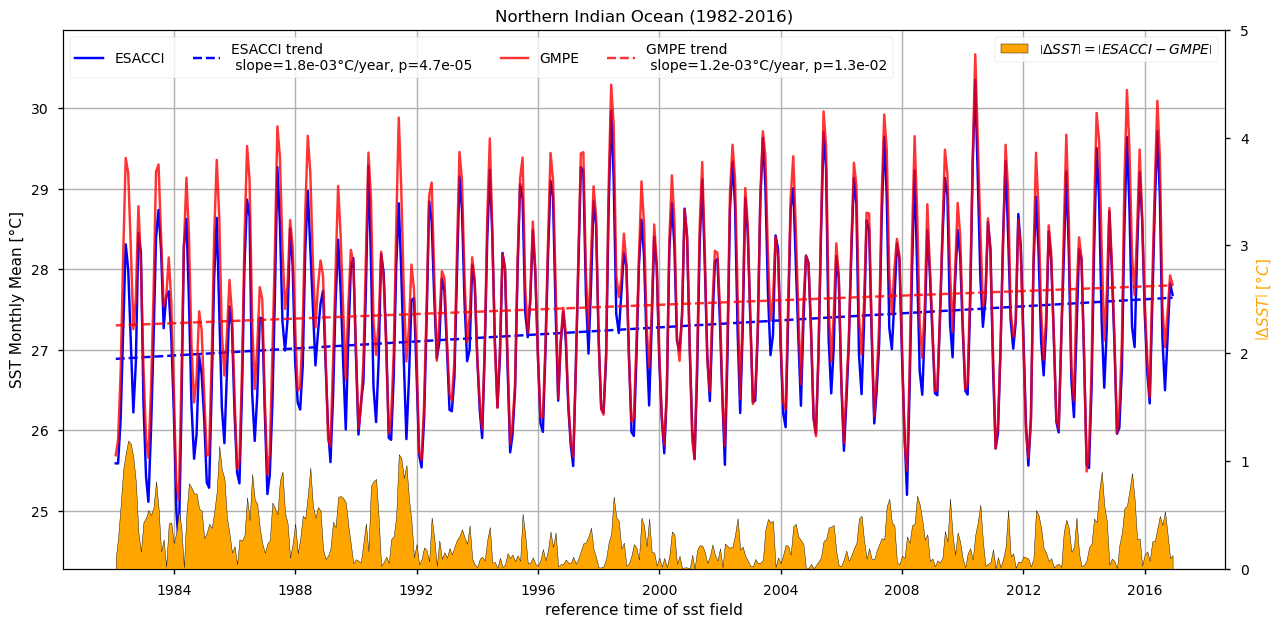

ESACCI in Tropical Atlantic: 0.0024 ± 0.0004 °C/year
GMPE in Tropical Atlantic: 0.002 ± 0.0004 °C/year


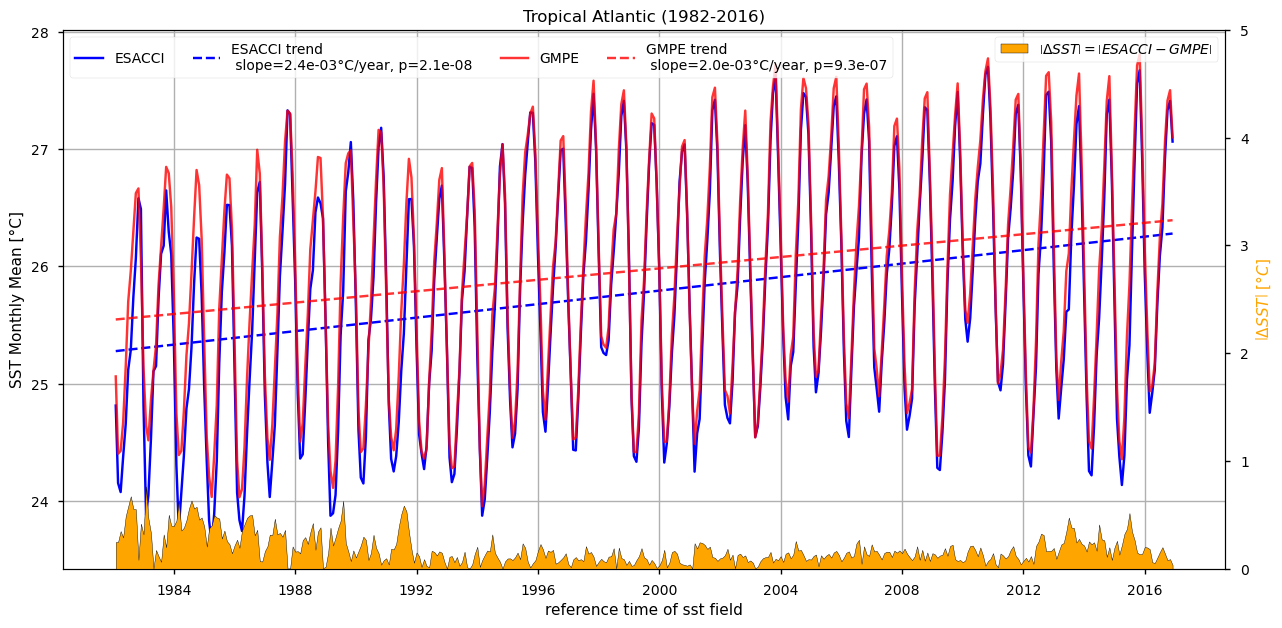

In [6]:
import pymannkendall as mk
import numpy as np
# Regions
regions = {
    "global": {"lon_slice": slice(glo[2], glo[3]), "lat_slice": slice(glo[0], glo[1])},
    "med sea": {"lon_slice": slice(med_sea[2], med_sea[3]), "lat_slice": slice(med_sea[0], med_sea[1])},
    "baltic sea": {"lon_slice": slice(baltic_sea[2], baltic_sea[3]), "lat_slice": slice(baltic_sea[0], baltic_sea[1])},
    "black sea": {"lon_slice": slice(black_sea[2], black_sea[3]), "lat_slice": slice(black_sea[0], black_sea[1])},
    "Tropical Atlantic": {"lon_slice": slice(tropAtl[2], tropAtl[3]), "lat_slice": slice(tropAtl[0],tropAtl[1])},
    "Northern Indian Ocean": {"lon_slice": slice(NorthInd[2], NorthInd[3]), "lat_slice": slice(NorthInd[0],NorthInd[1])},
}

def get_masked_sst(ds):
    da = ds["analysed_sst"]
    if "mask" in ds:
        da = da.where(ds["mask"] == 1)
    with xr.set_options(keep_attrs=True):
        da -= 273.15
    da.attrs["units"] = "°C"
    return da


def add_chunksizes(da):
    da.encoding["chunksizes"] = tuple(map(max, da.chunks))
    return da


def rechunk(obj):
    """Use NetCDF chunks."""
    chunks = {"time": 1, "year": 1, "season": 1, "latitude": 1_200, "longitude": 2_400}
    obj = obj.chunk(
        **{dim: chunksize for dim, chunksize in chunks.items() if dim in obj.dims}
    )
    if isinstance(obj, xr.DataArray):
        return add_chunksizes(obj)
    for da in obj.data_vars.values():
        add_chunksizes(da)
    return obj


def compute_regionalised_spatial_weighted_mean(ds, lon_slice, lat_slice):
    ds = rechunk(ds)
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    da = get_masked_sst(ds)
    return diagnostics.spatial_weighted_mean(da, weights=True).to_dataset()

datasets = []
for product, request_dict in request_dicts.items():
    for region, slices in regions.items():
        print(f"{product=} {region=}")
        for year in tqdm.tqdm(range(year_start, year_timeseries_stop + 1), desc="year"):
            requests = download.update_request_date(
                request_dict["request"],
                start=f"{year-1}-12",
                stop=f"{year}-11",
                stringify_dates=True,
            )
            ds = download.download_and_transform(
                collection_id=request_dict["collection_id"],
                requests=requests,
                chunks=request_dict["chunks"],
                transform_chunks=False,
                transform_func=compute_regionalised_spatial_weighted_mean,
                transform_func_kwargs=slices,
                **open_mfdataset_kwargs,
            )
            datasets.append(ds.expand_dims(product=[product], region=[region]).compute())
da = xr.merge(datasets)["analysed_sst"]
del datasets

colors = ["blue", "red"]
for region, da_region in da.groupby("region"):
    if region.title()=="Tropical Atlantic" or region.title()=="Northern Indian Ocean":
        fig, ax = plt.subplots(figsize=(15,7))
        for color, (product, da_product) in zip(colors, da_region.groupby("product")):
            da_product = da_product.squeeze()
            da_product = da_product.resample(time='1ME').mean().isel(time=slice(1, None)) #Originally was time='1Y' 20/03/2024
            if product=='GMPE':
                alpha=0.8
                diff = ((da_ref - da_product)**2)**0.5
                Ax = ax.twinx()
                Ax.fill_between(da_product['time'], 0., diff, color='orange', edgecolor='k', label=r'$\left|\Delta SST\right|= \left|ESACCI - GMPE\right|$')
                Ax.set_ylim(0., 5.)
                Ax.set_ylabel(r'$\left|\Delta SST\right| ~ [°C]$', color='orange')
            else:
                alpha=1.
                da_ref = da_product
            da_product.plot(ax=ax, label=product, color=color, alpha=alpha)
            trend, h, p, z, tau, s, var_s, slope, intercept = mk.original_test(da_product, alpha=0.05)
            ax.plot(
                da_product["time"],
                np.arange(da_product.sizes["time"]) * slope + intercept,
                label=f"{product} trend \n {slope=:.1e}°C/year, {p=:.1e}",
                color=color,
                ls="--",
                alpha=alpha,
            )
            ax.set_ylabel('SST Monthly Mean [°C]')
            ax.set_title(f"{region.title()} ({year_start}-{year_timeseries_stop})")
            z = -0.862 + (0.743 -2.404*np.log(p))**0.5
            SE = ((slope / z)**2)**0.5
            print(f"{product} in {region.title()}: {slope:.2} ± {SE:.1} °C/year")
        ax.legend(loc='upper left', ncol=4)
        Ax.legend(loc='upper right')
        ax.grid()
        plt.show()

In the 1982-1991 decade, the ESA CCI SSTs are generally colder than the GMPE ones, as sketched by the monthly time series presented in this section. This is also highlighted by the ∆SST time series (given in yellow), whose values can reach 1°C/0.6°C in the Indian Ocean and Tropical Atlantic, respectively, in the aforementioned temporal window. Such discrepancies are significantly reduced afterwards, thus resulting in a larger SST slope from the ESA CCI CDR, when compared with GMPE.  This is a known issue of the ESA CCI dataset, as reported in [[4]](https://doi.org/10.1038/s41597-019-0236-x): unscreened dust events caused negative biases in the Advanced Very High Resolution Radiometer (AVHRR) SSTs in the north East Tropical Atlantic and in the Arabian/Red Sea. This issue  covers the first decade of the CDR, resulting in anomalously high positive SST trends in these regions. 	

## ℹ️ If you want to know more

### Key resources

SST CCI Climate Assessment Report (CAR): https://climate.esa.int/media/documents/SST_CCI_D5.1_CAR_v1.1-signed.pdf

GHRSST Website: https://www.ghrsst.org/

Additional sources for SST ensemble intercomparison statistics: https://ghrsst-pp.metoffice.gov.uk/ostia-website/gmpe-monitoring.html

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)
* python packages: matplotlib, xarray, cartopy, numpy, tqdm
  
### References

[[1]](https://doi.org/10.1007/s00382-014-2147-z) Kang, S.M., Seager, R., Frierson, D.M.W. et al. Croll revisited: Why is the northern hemisphere warmer than the southern hemisphere?. Clim Dyn 44, 1457–1472 (2015). https://doi.org/10.1007/s00382-014-2147-z

[[2]](https://doi.org/10.1175/JCLI-D-20-0793.1) Yang, C., Leonelli, F. E., Marullo, S., Artale, V., Beggs, H., Nardelli, B. B., ... & Pisano, A. (2021). Sea surface temperature intercomparison in the framework of the Copernicus Climate Change Service (C3S). Journal of Climate, 34(13), 5257-5283

[[3]](https://doi.org/10.1016/j.rse.2018.12.015) Fiedler, E. K., McLaren, A., Banzon, V., Brasnett, B., Ishizaki, S., Kennedy, J., ... & Donlon, C. (2019). Intercomparison of long-term sea surface temperature analyses using the GHRSST Multi-Product Ensemble (GMPE) system. Remote sensing of environment, 222, 18-33

[[4]](https://doi.org/10.1038/s41597-019-0236-x) Merchant, C. J., Embury, O., Bulgin, C. E., Block, T., Corlett, G. K., Fiedler, E., ... & Donlon, C. (2019). Satellite-based time-series of sea-surface temperature since 1981 for climate applications. Scientific data, 6(1), 223. https://doi.org/10.1038/s41597-019-0236-x

[[5]](https://doi.org/10.3390/rs12010132) Pisano, A., Marullo, S., Artale, V., Falcini, F., Yang, C., Leonelli, F. E., Santoleri, R. and Buongiorno Nardelli, B.: New Evidence of Mediterranean Climate Change and Variability from Sea Surface Temperature Observations, Remote Sens., 12(1), 132, doi:10.3390/rs12010132, 2020

[[6]](https://doi.org/10.1080/1755876X.2018.1489208) Mulet, S., Buongiorno Nardelli, B., Good, S., Pisano, A., Greiner, E., Monier, M., Autret, E., Axell, L., Boberg, F., Ciliberti, S., Drévillon, M., Droghei, R., Embury, O., Gourrion, J., Høyer, J., Juza, M., Kennedy, J., Lemieux-Dudon, B., Peneva, E., Reid, R., Simoncelli, S., Storto, A., Tinker, J., Von Schuckmann, K., Wakelin, S. L., 2018. Ocean temperature and salinity. In: Copernicus Marine Service Ocean State Report, Issue 2, Journal of Operational Oceanography, 11:sup1, s5–s13, DOI: 10.1080/1755876X.2018.1489208

[[7]](http://hdl.handle.net/10013/epic.45156.d001) Pachauri, R. K., Allen, M. R., Barros, V. R., Broome, J., Cramer, W., Christ, R., Church, J. A., Clarke, L., Dahe, Q., Dasgupta, P., Dubash, N. K., et al.: Climate Change 2014: Synthesis Report. Contribution of Working Groups I, II and III to the Fifth Assessment Report of the Intergovernmental Panel on Climate Change, edited by: Pachauri, R. and Meyer, L., Geneva, Switzerland, IPCC, ISBN 978-92-9169-143-2, 2014